In [109]:
# Libraries for data preprocessing
import pandas as pd
import numpy as np

# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
import tensorflow as tf
import cv2
from PIL import Image

# Transfer learning Libraries
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0,MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

import os
import random

In [108]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [79]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.set_visible_devices(physical_devices[0], 'GPU')

### Reading in the Dataset

In [110]:
# # Unzippping the dataset
# import zipfile
# with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
#      zip_ref.extractall(r'''\\adir.hull.ac.uk\home\700\700970\Downloads\emotion_detection''')

In [111]:
#getting the train directory
train_dir = './train'

#getting the test directory
test_dir =  './test'

### Preprocessing the dataset

In [112]:
# creating the datagenerator that will read in the images stored as train images
datagen = ImageDataGenerator(rescale=1./255)

In [113]:
# Flow training images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
train_data = image_dataset_from_directory(directory=train_dir,
                                              seed=72,
                                              shuffle=True,
                                              validation_split = 0.20,
                                              batch_size = 70,
                                              #color_mode = 'grayscale',
                                              label_mode='categorical',
                                              image_size=(124,124),
                                              subset='training') 


# Flow validation images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
val_data = image_dataset_from_directory(directory=train_dir,
                                            shuffle=True,
                                            batch_size = 70,
                                            validation_split = 0.05,
                                            seed= 72,
                                            #color_mode = 'grayscale',
                                            label_mode='categorical',
                                            image_size=(124,124),
                                            subset='validation')
# Flow test images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
test_data = image_dataset_from_directory(directory=test_dir,
                                            shuffle=True,
                                            batch_size = 70,
                                            seed= 72,
                                            #color_mode = 'grayscale',
                                            label_mode='categorical',
                                            image_size=(124,124))


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 1435 files for validation.
Found 7178 files belonging to 7 classes.


In [114]:
# Check dimension of the train generator
next(iter(train_data))[0].shape

TensorShape([70, 124, 124, 3])

In [115]:
# Check dimension of the validation generator
next(iter(val_data))[0].shape

TensorShape([70, 124, 124, 3])

In [116]:
class_names = train_data.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


### Configuring the dataset for perfomance

In [117]:
# # Using buffers prefetching to load images from disk 
AUTOTUNE = tf.data.AUTOTUNE
train_data= train_data.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

### Using Data Augumentation

In [118]:
# tranforming the dataset by randomly flipping ,rotating the dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

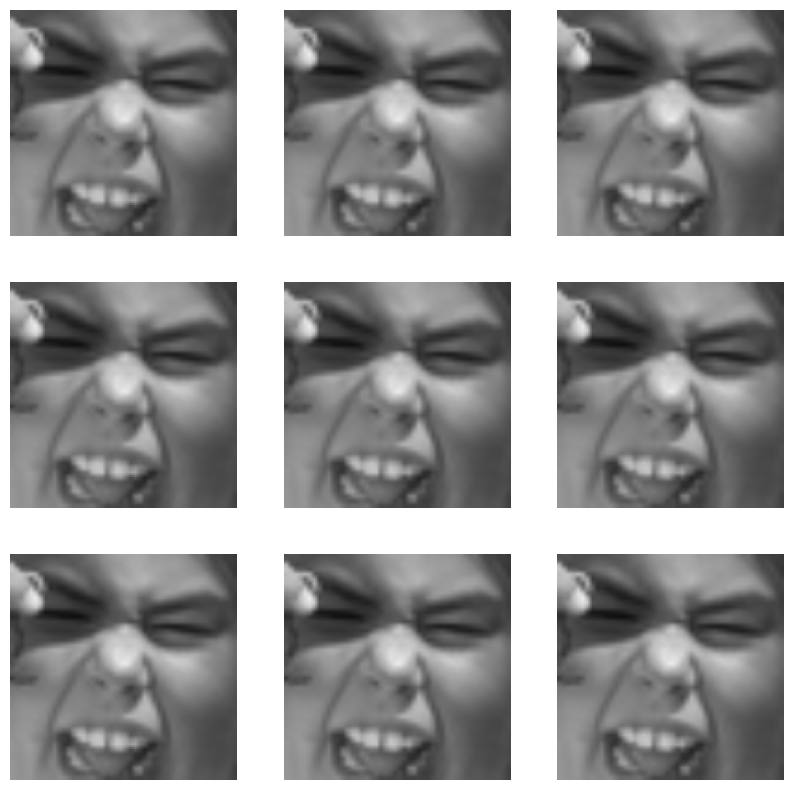

In [119]:
# Applying the augmentation to the first image repeatedly
for image,_ in train_data.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i +1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

### Building the custom built CNN model

In [20]:
# Set the image dimensions
IMG_WIDTH = 124
IMG_HEIGHT = 124
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
epochs = 120
batch_size = 32

In [21]:
# Instantiating the custom built model
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))  # add dropout here

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l1(0.002)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5)) 

model.add(Dense(512,activation = 'relu'))
model.add(Dense(7, activation='softmax'))

In [22]:
# Compiling the model with categorical crossentropy and Adam optimizer
model.compile(
     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
     loss='categorical_crossentropy',
     metrics=['accuracy'])

In [23]:
# Checking the summary of the built model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 41, 41, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 128)       204928    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                  

In [24]:
from keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [25]:
# Training the model 
history = model.fit(train_data,
                    epochs = epochs,
                    validation_data = val_data,
                    batch_size = batch_size,
                    verbose = 2)

Epoch 1/120
329/329 - 54s - loss: 55.1043 - accuracy: 0.2238 - val_loss: 44.5671 - val_accuracy: 0.2404 - 54s/epoch - 164ms/step
Epoch 2/120
329/329 - 12s - loss: 36.0232 - accuracy: 0.2496 - val_loss: 28.4278 - val_accuracy: 0.2404 - 12s/epoch - 38ms/step
Epoch 3/120
329/329 - 11s - loss: 22.5660 - accuracy: 0.2503 - val_loss: 17.5081 - val_accuracy: 0.2404 - 11s/epoch - 33ms/step
Epoch 4/120
329/329 - 11s - loss: 13.7412 - accuracy: 0.2503 - val_loss: 10.5783 - val_accuracy: 0.2404 - 11s/epoch - 33ms/step
Epoch 5/120
329/329 - 11s - loss: 8.3038 - accuracy: 0.2504 - val_loss: 6.4580 - val_accuracy: 0.2404 - 11s/epoch - 33ms/step
Epoch 6/120
329/329 - 11s - loss: 5.1841 - accuracy: 0.2503 - val_loss: 4.2034 - val_accuracy: 0.2404 - 11s/epoch - 32ms/step
Epoch 7/120
329/329 - 11s - loss: 3.5292 - accuracy: 0.2505 - val_loss: 3.0423 - val_accuracy: 0.2404 - 11s/epoch - 33ms/step
Epoch 8/120
329/329 - 11s - loss: 2.7312 - accuracy: 0.2504 - val_loss: 2.5193 - val_accuracy: 0.2404 - 11s/e

Epoch 66/120
329/329 - 11s - loss: 1.0738 - accuracy: 0.6459 - val_loss: 1.1764 - val_accuracy: 0.6091 - 11s/epoch - 32ms/step
Epoch 67/120
329/329 - 11s - loss: 1.0630 - accuracy: 0.6533 - val_loss: 1.1818 - val_accuracy: 0.6084 - 11s/epoch - 33ms/step
Epoch 68/120
329/329 - 11s - loss: 1.0624 - accuracy: 0.6577 - val_loss: 1.1731 - val_accuracy: 0.6118 - 11s/epoch - 32ms/step
Epoch 69/120
329/329 - 11s - loss: 1.0577 - accuracy: 0.6593 - val_loss: 1.1830 - val_accuracy: 0.6000 - 11s/epoch - 32ms/step
Epoch 70/120
329/329 - 11s - loss: 1.0500 - accuracy: 0.6597 - val_loss: 1.1759 - val_accuracy: 0.6181 - 11s/epoch - 33ms/step
Epoch 71/120
329/329 - 11s - loss: 1.0408 - accuracy: 0.6641 - val_loss: 1.1867 - val_accuracy: 0.6056 - 11s/epoch - 33ms/step
Epoch 72/120
329/329 - 11s - loss: 1.0419 - accuracy: 0.6597 - val_loss: 1.1728 - val_accuracy: 0.6091 - 11s/epoch - 33ms/step
Epoch 73/120
329/329 - 11s - loss: 1.0396 - accuracy: 0.6640 - val_loss: 1.1801 - val_accuracy: 0.6077 - 11s/ep

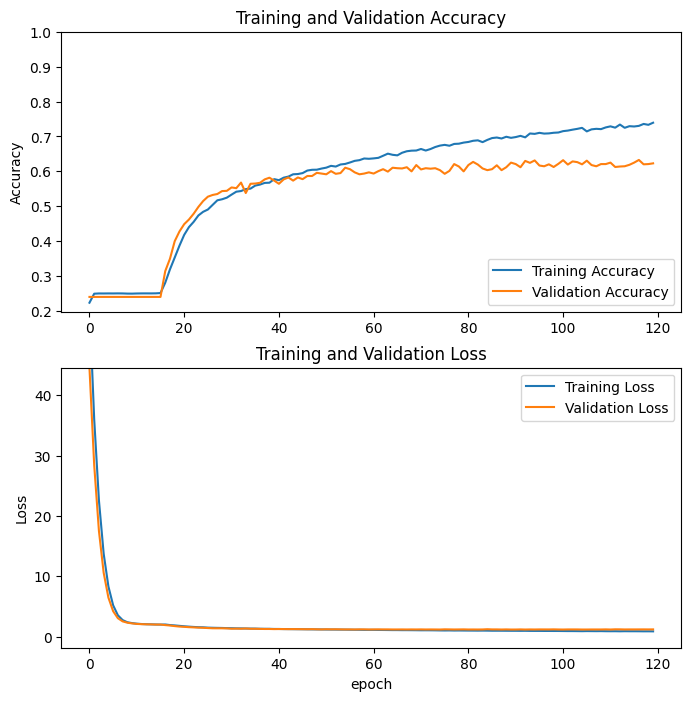

In [26]:
# Plotting the learning curve
train_acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()), max(val_loss)])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

#### Saving the custom model

In [27]:
#model.save('custom_emotion_model.h5')

In [28]:
#model.save('custom_emotion_model2.h5')

In [29]:
#model.save('custom_emotion_model3.h5')

##### Model Evaluation 

In [38]:
print('Testing Acuaracy',model.evaluate(test_data))

103/103 [==============================] - 12s 104ms/step - loss: 1.2672 - accuracy: 0.6055
Testing Acuaracy [1.2672227621078491, 0.6054611206054688]


### Using Transfer Learning Algorithms 

#### Using Mobilenet

In [120]:
# Set the image dimensions
img_size = (124,124)
batch_size = 32
IMG_WIDTH = 124
IMG_HEIGHT = 124
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)

In [121]:
# Preprocess the image using mobilenet preprocess_input function
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [122]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [123]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = img_size + (3,)
mobilenet_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [124]:
image_batch, label_batch = next(iter(train_data))
feature_batch = mobilenet_base_model(image_batch)
print(feature_batch.shape)

(70, 4, 4, 1280)


In [125]:
### Freeze the convolutional Layer
mobilenet_base_model.trainable = False

In [126]:
mobilenet_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 124, 124, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 62, 62, 32)   864         ['input_19[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 62, 62, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 62, 62, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [135]:
# Reducing the spatial dimension of the input feature and applying it to the feature batch 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(70, 1280)


In [136]:
# Applying a dense layer to convert the features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(70, 7)


In [137]:
# ## Building a model by chaining together the data augumentation,rescaling, mobilnet model and feature extractor
# # Define the input shape for the model
# inputs_mobilenet = tf.keras.Input(shape=input_shape)

# # Apply data augmentation to the input data
# x = data_augmentation(inputs_mobilenet)

# # Preprocess the input data using the mobilenet preprocessing function
# x = preprocess_input(x)

# # Load the pre-trained mobilnet model and apply it to the preprocessed input data
# mobilenet_base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
# x = mobilenet_base_model(x)

# # Apply global average pooling to the output of the mobilnet model
# x = tf.keras.layers.MaxPooling2D()(x)

# # Apply dropout regularization to prevent overfitting
# x = tf.keras.layers.Dropout(0.2)(x)

# # Apply output layers for the model
# outputs_mobilenet = tf.keras.layers.Dense(7,activation='sigmoid')(x)

# # Define the input and output layers for the model
# mobilenet_model = tf.keras.Model(inputs_mobilenet,outputs_mobilenet)

In [138]:
inputs = tf.keras.Input(shape=(124,124, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

In [139]:
# Taking a look at the base model architecture
mobilenet_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 124, 124, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 124, 124, 3)       0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 124, 124, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 124, 124, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [140]:
# # Add the prediction layer to the model
# x = prediction_layer(x)

# # Modify dense layer to have 128 units instead of 1280
# x = tf.keras.layers.Dense(units=128, activation='relu')(x)

# # Add another dense layer with 64 units
# x = tf.keras.layers.Dense(units=64, activation='relu')(x)

# # Add another dense layer with 32 units
# x = tf.keras.layers.Dense(units=32, activation='relu')(x)

# # Add another dense layer with 16 units
# x = tf.keras.layers.Dense(units=16, activation='relu')(x)

# # Add the final output layer with 7 units and softmax activation
# outputs = tf.keras.layers.Dense(units=7, activation='softmax')(x)

# # Define the model inputs and outputs
# mobilenet_model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [141]:
# Compiling the model
learning_rate = 0.0001
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [142]:
# Checking the trainable variable objects
len(mobilenet_model.trainable_variables)

158

In [143]:
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=10,
                                        validation_data=val_data)


Epoch 1/10


NotFoundError: Graph execution error:

Detected at node 'model_9/mobilenetv2_1.00_224/block_10_project/Conv2D' defined at (most recent call last):
    File "C:\Users\franc\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\franc\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\franc\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\franc\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\franc\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\franc\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\franc\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\franc\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\franc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\franc\AppData\Local\Temp/ipykernel_5848/2158452712.py", line 1, in <cell line: 1>
      mobilenet_history = mobilenet_model.fit(train_data,
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_9/mobilenetv2_1.00_224/block_10_project/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16926208 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 23658496 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 163790848 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 58347520 bytes.
	 [[{{node model_9/mobilenetv2_1.00_224/block_10_project/Conv2D}}]] [Op:__inference_train_function_106412]